In [1]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [81]:
!pip install scikit-learn==1.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 42.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold,train_test_split,GridSearchCV
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan,acorr_breusch_godfrey
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from scipy.stats import linregress, pearsonr
from scipy.stats import f,t
import xgboost as xgb

In [ ]:
# import os

# print(os.listdir())

# for file in os.listdir():
#     if file.startswith('model_features_daily'):
#         os.remove(file)

['.config', 'model_features_daily (1).csv', 'model_features_daily (5).csv', 'model_features_daily (3).csv', 'model_features_daily (4).csv', 'model_features_daily (2).csv', 'model_features_daily.csv', 'sample_data']


In [2]:
from google.colab import files

uploaded = files.upload()

Saving model_features_daily.csv to model_features_daily (1).csv


# Valuing Hard Commodities in Dynamic Climate
---
## Part 3: Hard Commodities Valuation Model
- **Period**: December 2023 to November 2024
- **Target Variable**: WTI Futures Price
- **Content**
  1. **Preliminary Analysis**
  2. **Data Preprocessing**
  3. **Multiple Regression Model (Initial Overview)**
    - Raw data used in an unscaled multiple regression to assess data fit without tuning.
  4. **Model Performance Comparison**
      - **4.1 Multiple Regression Model**
        - Assumption Checks
        - Cleaned model (excluding influential points based on studentized residuals)
      - **4.2 XGBoost**
        - Model 1: Hyperparameter tuning to identify optimal model
        - Model 2: No hyperparameter tuning
        - Model 3: Self-adjusted hyperparameters
      - **4.3 LSTM**

In [3]:
pd.options.display.max_columns = 999

In [4]:
df = pd.read_csv('model_features_daily.csv')
df.head()

Date    close_cop  volume_cop  close_alu  volume_alu   close_gold  \
0  2023-12-01  8617.859403        2050    2174.50        20.0  2071.000000   
1  2023-12-04  8422.750483         963    2148.75        20.0  2024.099976   
2  2023-12-05  8316.929034         971    2126.00        20.0  2018.500000   
3  2023-12-06  8193.470327         551    2109.75        20.0  2030.500000   
4  2023-12-07  8343.384133         721    2092.50        35.0  2029.900024   

   volume_gold  close_wti  volume_wti  close_ng  volume_ng       close_b  \
0        614.0  74.070000    358976.0     2.814     133190  38688.750000   
1       1071.0  73.040001    388832.0     2.694     161786  41980.097656   
2        289.0  72.320000    358703.0     2.710     119974  44080.648438   
3        417.0  69.379997    436803.0     2.569     218374  43746.445312   
4         67.0  69.339996    339000.0     2.585     248396  43292.664062   

      volume_b    close_eth   volume_eth    vix   usdEUR  ele_total    ele_ng  \
0  23512784002  2087.139893  10866891430  12.63  0.91810   54235932  23442631   
1  39856129827  2243.215820  16149367134  13.08  0.91843   53753188  23089546   
2  36312154535  2293.841797  15383072559  12.85  0.92270   55043618  24100581   
3  29909761586  2231.661377  12790612571  12.97  0.92647   55980891  22593816   
4  27635760671  2357.579590  14766891042  13.06  0.92879   56379352  20830353   

   ele_oil  ele_demand  ele_ic  
0    43313    54439236  163609  
1    43611    54059830   57634  
2    46291    55294658   51512  
3    47211    56212967   20743  
4    45043    56739527   34465

## 1. Preliminary Analysis
---
- **Scatter Plot Matrix**
  - ...
- **Correlation Analysis**
  - ...


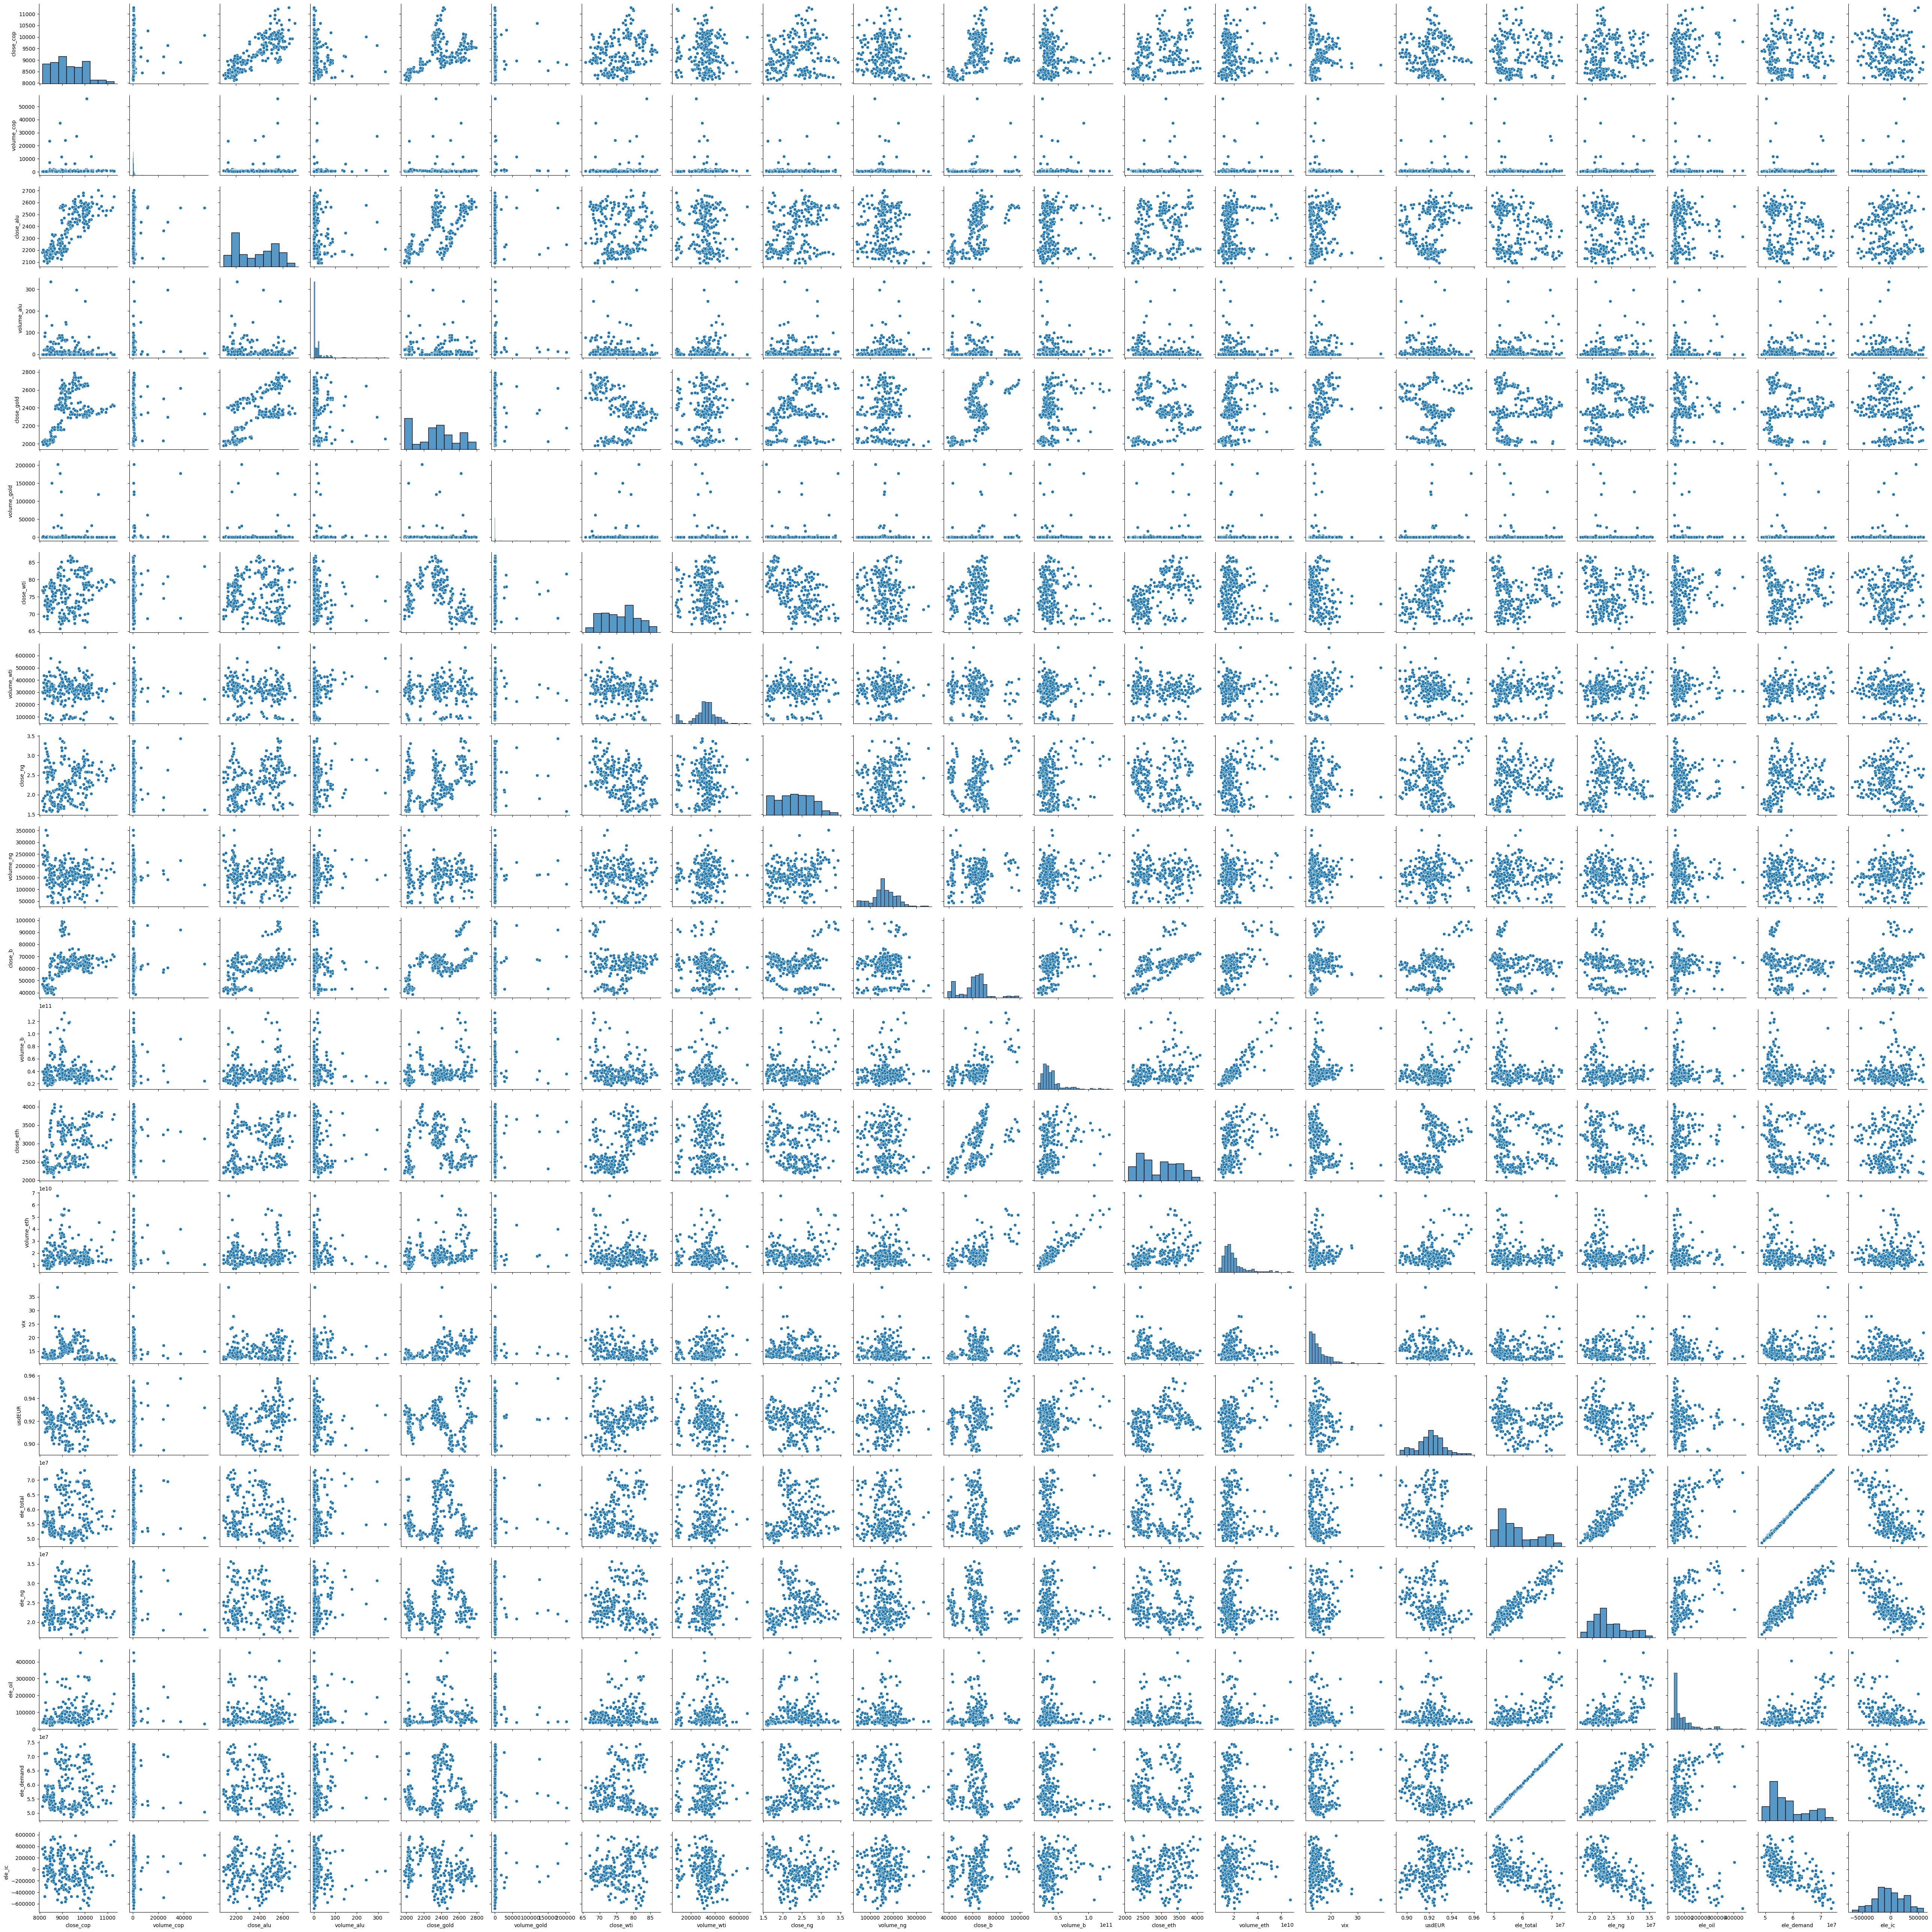

In [10]:
# Scatterplot Matrix (with all features)
sns.pairplot(df)
plt.show()

In [5]:
# Correlation Table
correlation_matrix = df.drop(columns=['Date']).corr()
correlation_matrix

close_cop  volume_cop  close_alu  volume_alu  close_gold  \
close_cop     1.000000    0.033062   0.814542   -0.177562    0.547208   
volume_cop    0.033062    1.000000   0.077619    0.131264    0.021495   
close_alu     0.814542    0.077619   1.000000   -0.156674    0.708978   
volume_alu   -0.177562    0.131264  -0.156674    1.000000   -0.067539   
close_gold    0.547208    0.021495   0.708978   -0.067539    1.000000   
volume_gold  -0.041409    0.233498   0.009754    0.005055   -0.011920   
close_wti     0.280645    0.062464  -0.009843   -0.182665   -0.299092   
volume_wti   -0.039026   -0.033517  -0.073168    0.212082    0.049168   
close_ng      0.194508   -0.027294   0.351179    0.053071    0.289562   
volume_ng    -0.063877    0.001046  -0.023415    0.095758   -0.004983   
close_b       0.441165    0.097940   0.608293   -0.170512    0.675810   
volume_b     -0.102955    0.055487   0.109459   -0.068540    0.267077   
close_eth     0.398462    0.087028   0.254133   -0.158068    0.044001   
volume_eth   -0.003376    0.038310   0.139675   -0.089142    0.278356   
vix           0.004682   -0.055729   0.126334    0.044571    0.541300   
usdEUR        0.085785    0.139943   0.230415   -0.153290   -0.067278   
ele_total     0.076450   -0.018431  -0.218291    0.148489    0.047221   
ele_ng        0.082968   -0.044599  -0.175622    0.134198    0.205150   
ele_oil       0.307574    0.009364   0.058209    0.061416    0.160693   
ele_demand    0.074084   -0.021386  -0.214888    0.148000    0.058887   
ele_ic       -0.156744    0.051170  -0.023477   -0.094270   -0.276234   

             volume_gold  close_wti  volume_wti  close_ng  volume_ng  \
close_cop      -0.041409   0.280645   -0.039026  0.194508  -0.063877   
volume_cop      0.233498   0.062464   -0.033517 -0.027294   0.001046   
close_alu       0.009754  -0.009843   -0.073168  0.351179  -0.023415   
volume_alu      0.005055  -0.182665    0.212082  0.053071   0.095758   
close_gold     -0.011920  -0.299092    0.049168  0.289562  -0.004983   
volume_gold     1.000000  -0.000529   -0.025510  0.024538   0.027062   
close_wti      -0.000529   1.000000   -0.114160 -0.538372  -0.179535   
volume_wti     -0.025510  -0.114160    1.000000  0.023452   0.037806   
close_ng        0.024538  -0.538372    0.023452  1.000000   0.216619   
volume_ng       0.027062  -0.179535    0.037806  0.216619   1.000000   
close_b         0.118385   0.013586   -0.073047  0.161342   0.063444   
volume_b        0.051369  -0.202709    0.006891  0.133937   0.167772   
close_eth       0.117009   0.563642   -0.075906 -0.161837  -0.024091   
volume_eth      0.053113  -0.155788    0.031487  0.166603   0.092620   
vix            -0.057921  -0.272039    0.219209 -0.098171   0.017356   
usdEUR          0.129964   0.258387   -0.166108  0.053805   0.110584   
ele_total      -0.030006   0.051297    0.099034  0.136394  -0.026103   
ele_ng         -0.041848  -0.051933    0.158729  0.111860  -0.091185   
ele_oil        -0.050257   0.122419    0.033847  0.050918  -0.010587   
ele_demand     -0.031941   0.034161    0.102963  0.146745  -0.025932   
ele_ic          0.056445   0.181910   -0.161557 -0.251396   0.058985   

              close_b  volume_b  close_eth  volume_eth       vix    usdEUR  \
close_cop    0.441165 -0.102955   0.398462   -0.003376  0.004682  0.085785   
volume_cop   0.097940  0.055487   0.087028    0.038310 -0.055729  0.139943   
close_alu    0.608293  0.109459   0.254133    0.139675  0.126334  0.230415   
volume_alu  -0.170512 -0.068540  -0.158068   -0.089142  0.044571 -0.153290   
close_gold   0.675810  0.267077   0.044001    0.278356  0.541300 -0.067278   
volume_gold  0.118385  0.051369   0.117009    0.053113 -0.057921  0.129964   
close_wti    0.013586 -0.202709   0.563642   -0.155788 -0.272039  0.258387   
volume_wti  -0.073047  0.006891  -0.075906    0.031487  0.219209 -0.166108   
close_ng     0.161342  0.133937  -0.161837    0.166603 -0.098171  0.053805   
volume_ng    0.063444  0.167772  -0.02409

In [6]:
# Find pairs with high correlation (absolute value > 0.6)
high_corr_pairs = []
threshold = 0.6

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_value))


if high_corr_pairs:
    print("Highly correlated variable pairs (|correlation| > 0.6):")
    for var1, var2, corr in high_corr_pairs:
        print(f"{var1} and {var2}: {corr:.3f}")
else:
    print("No pairs found with |correlation| > 0.6.")

Highly correlated variable pairs (|correlation| > 0.6):
close_cop and close_alu: 0.815
close_alu and close_gold: 0.709
close_alu and close_b: 0.608
close_gold and close_b: 0.676
close_b and close_eth: 0.638
volume_b and volume_eth: 0.915
ele_total and ele_ng: 0.926
ele_total and ele_oil: 0.623
ele_total and ele_demand: 0.999
ele_total and ele_ic: -0.675
ele_ng and ele_demand: 0.931
ele_ng and ele_ic: -0.741
ele_oil and ele_demand: 0.624
ele_demand and ele_ic: -0.691


In [7]:
df.columns

Index(['Date', 'close_cop', 'volume_cop', 'close_alu', 'volume_alu',
       'close_gold', 'volume_gold', 'close_wti', 'volume_wti', 'close_ng',
       'volume_ng', 'close_b', 'volume_b', 'close_eth', 'volume_eth', 'vix',
       'usdEUR', 'ele_total', 'ele_ng', 'ele_oil', 'ele_demand', 'ele_ic'],
      dtype='object')

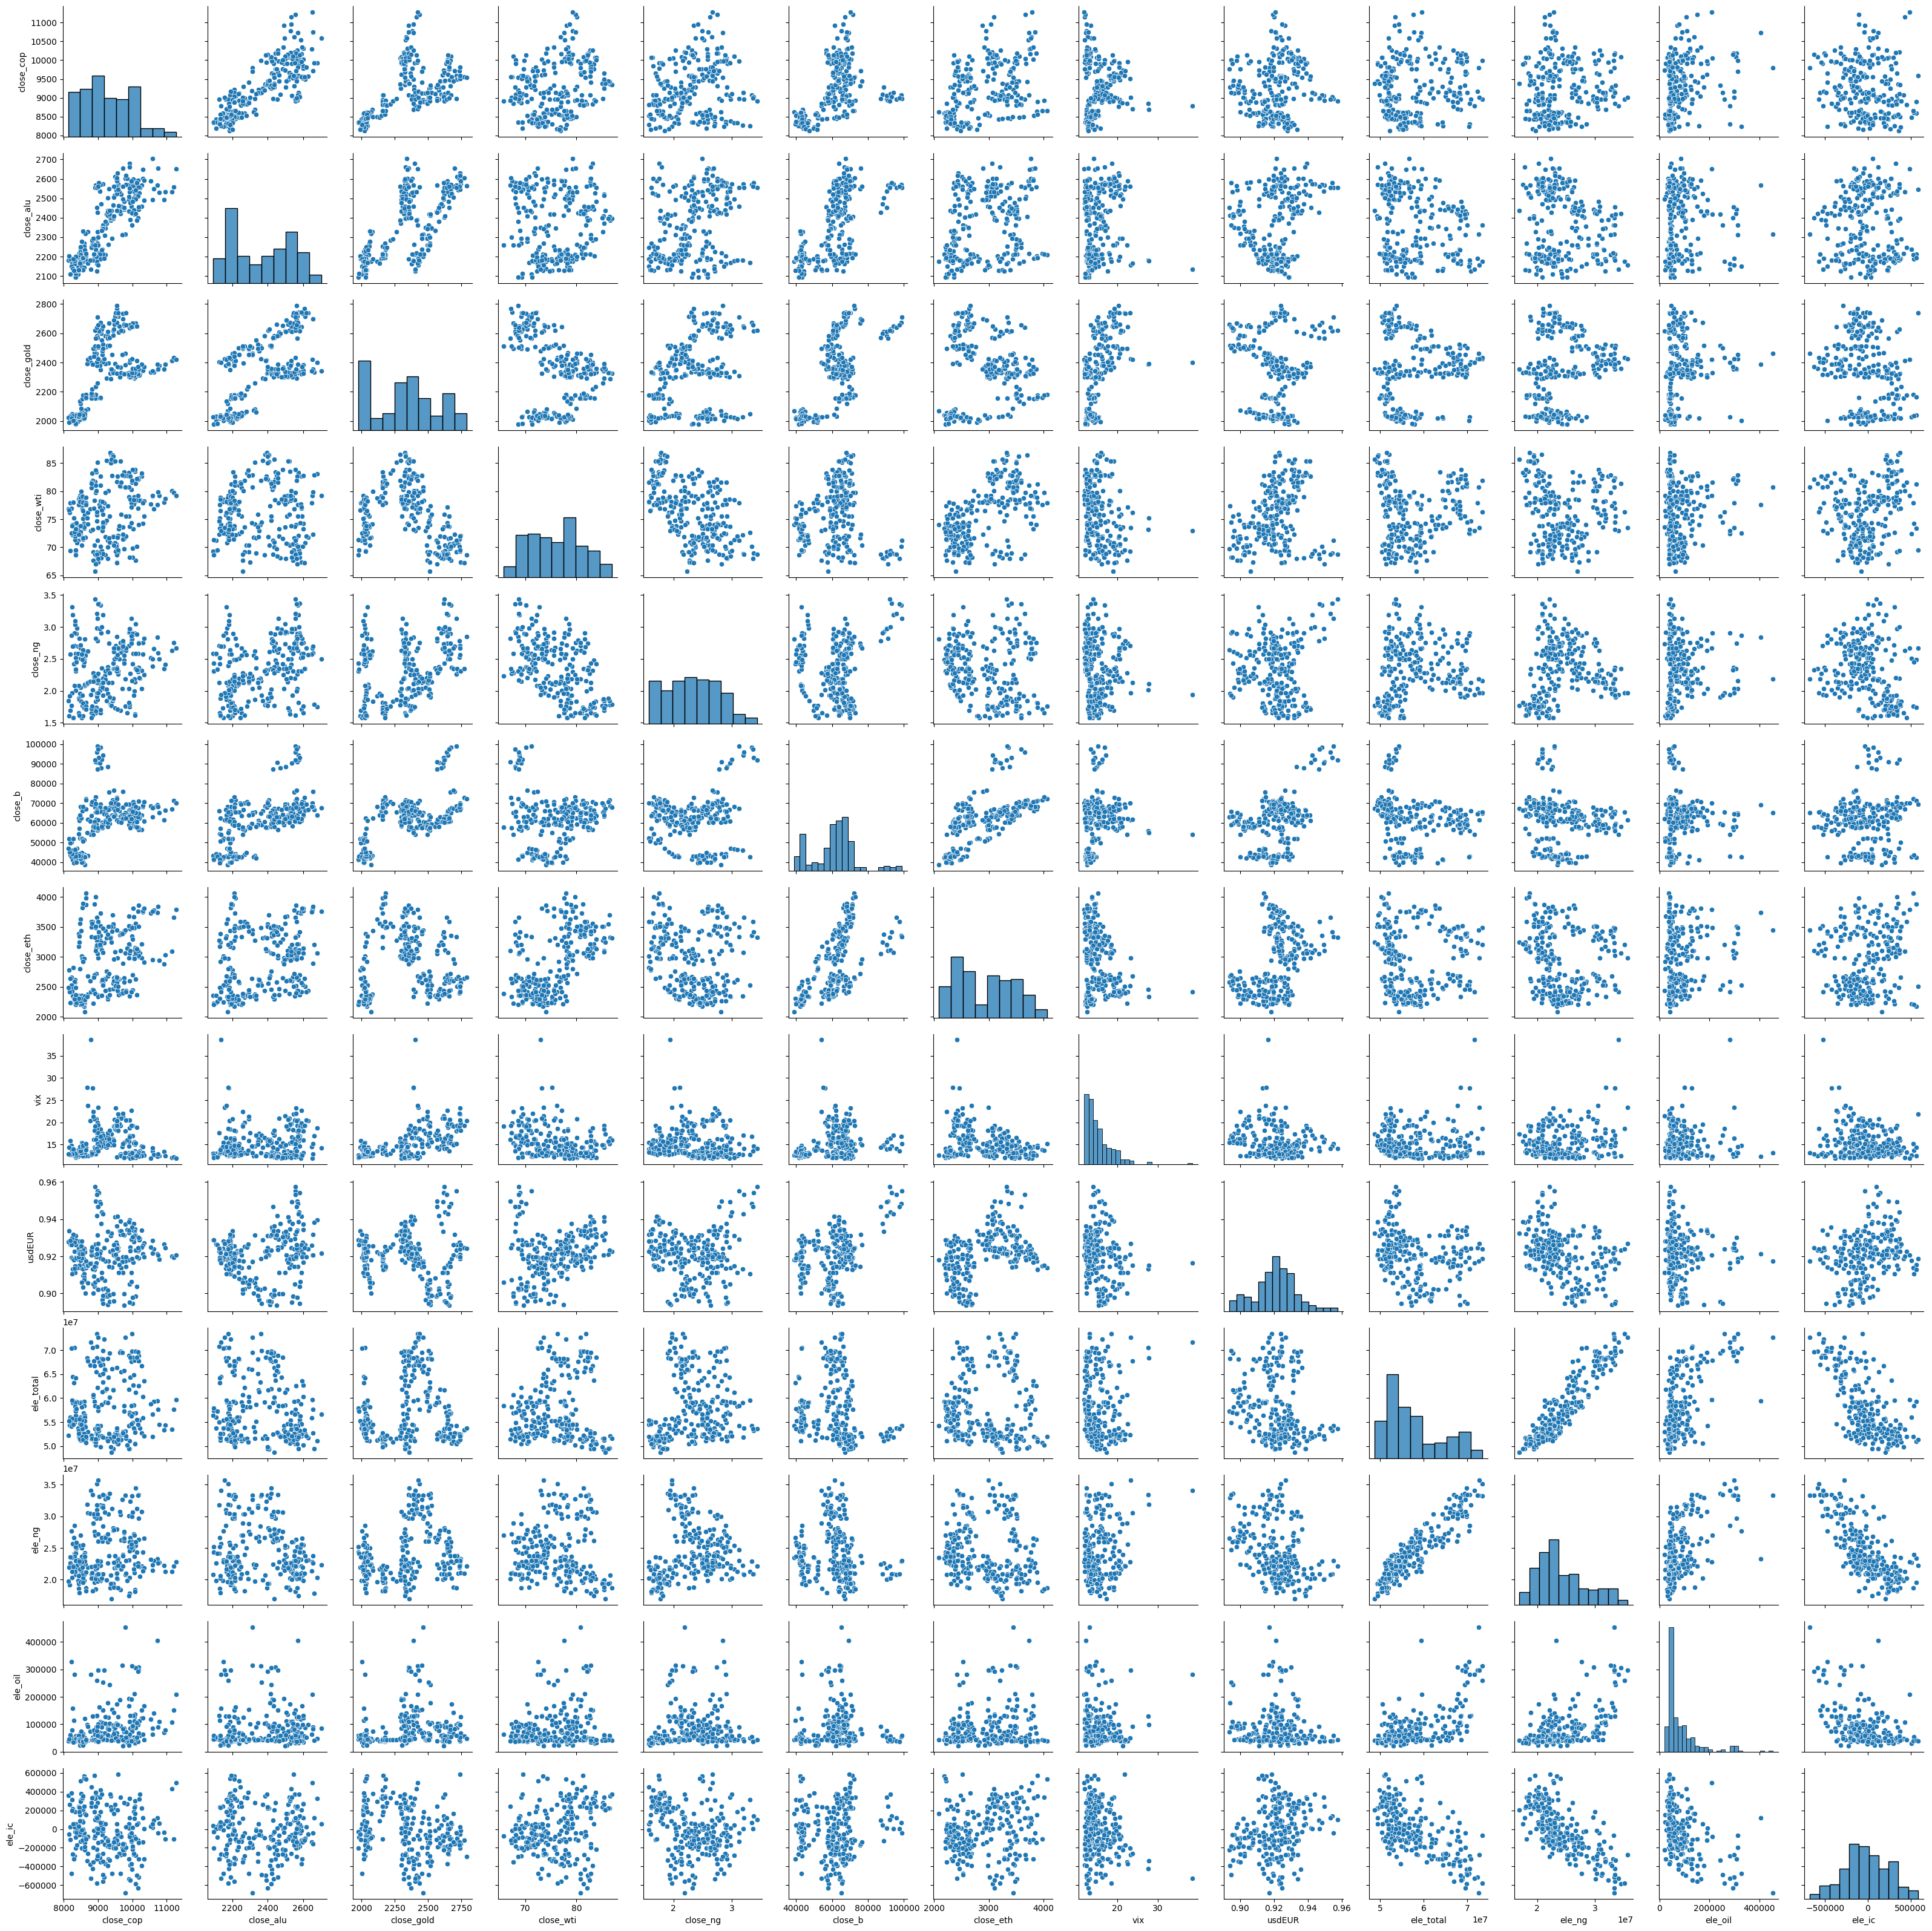

In [8]:
df_f = df.drop(columns=['volume_cop','volume_alu','volume_gold','volume_wti','volume_ng','volume_b','volume_eth','ele_demand'])

# Scatterplot Matrix (with filtered features)
sns.pairplot(df_f)
plt.show()

In [9]:
df_f.drop(columns=['Date']).corr()

close_cop  close_alu  close_gold  close_wti  close_ng   close_b  \
close_cop    1.000000   0.814542    0.547208   0.280645  0.194508  0.441165   
close_alu    0.814542   1.000000    0.708978  -0.009843  0.351179  0.608293   
close_gold   0.547208   0.708978    1.000000  -0.299092  0.289562  0.675810   
close_wti    0.280645  -0.009843   -0.299092   1.000000 -0.538372  0.013586   
close_ng     0.194508   0.351179    0.289562  -0.538372  1.000000  0.161342   
close_b      0.441165   0.608293    0.675810   0.013586  0.161342  1.000000   
close_eth    0.398462   0.254133    0.044001   0.563642 -0.161837  0.637552   
vix          0.004682   0.126334    0.541300  -0.272039 -0.098171  0.154075   
usdEUR       0.085785   0.230415   -0.067278   0.258387  0.053805  0.407487   
ele_total    0.076450  -0.218291    0.047221   0.051297  0.136394 -0.179671   
ele_ng       0.082968  -0.175622    0.205150  -0.051933  0.111860 -0.136118   
ele_oil      0.307574   0.058209    0.160693   0.122419  0.050918  0.034633   
ele_ic      -0.156744  -0.023477   -0.276234   0.181910 -0.251396  0.068591   

            close_eth       vix    usdEUR  ele_total    ele_ng   ele_oil  \
close_cop    0.398462  0.004682  0.085785   0.076450  0.082968  0.307574   
close_alu    0.254133  0.126334  0.230415  -0.218291 -0.175622  0.058209   
close_gold   0.044001  0.541300 -0.067278   0.047221  0.205150  0.160693   
close_wti    0.563642 -0.272039  0.258387   0.051297 -0.051933  0.122419   
close_ng    -0.161837 -0.098171  0.053805   0.136394  0.111860  0.050918   
close_b      0.637552  0.154075  0.407487  -0.179671 -0.136118  0.034633   
close_eth    1.000000 -0.299111  0.422848  -0.011639 -0.126456  0.151244   
vix         -0.299111  1.000000 -0.205501   0.053092  0.200616  0.047634   
usdEUR       0.422848 -0.205501  1.000000  -0.248358 -0.360565 -0.062424   
ele_total   -0.011639  0.053092 -0.248358   1.000000  0.925707  0.623283   
ele_ng      -0.126456  0.200616 -0.360565   0.925707  1.000000  0.580561   
ele_oil      0.151244  0.047634 -0.062424   0.623283  0.580561  1.000000   
ele_ic       0.144021 -0.215583  0.242454  -0.675487 -0.740936 -0.482965   

              ele_ic  
close_cop  -0.156744  
close_alu  -0.023477  
close_gold -0.276234  
close_wti   0.181910  
close_ng   -0.251396  
close_b     0.068591  
close_eth   0.144021  
vix        -0.215583  
usdEUR      0.242454  
ele_total  -0.675487  
ele_ng     -0.740936  
ele_oil    -0.482965  
ele_ic      1.000000

In [10]:
df_filtered = df.drop(columns=['close_eth', 'volume_eth','ele_demand'])
df_filtered

Date    close_cop  volume_cop  close_alu  volume_alu   close_gold  \
0    2023-12-01  8617.859403        2050    2174.50        20.0  2071.000000   
1    2023-12-04  8422.750483         963    2148.75        20.0  2024.099976   
2    2023-12-05  8316.929034         971    2126.00        20.0  2018.500000   
3    2023-12-06  8193.470327         551    2109.75        20.0  2030.500000   
4    2023-12-07  8343.384133         721    2092.50        35.0  2029.900024   
..          ...          ...         ...        ...         ...          ...   
246  2024-11-22  8981.621619         514    2556.00         0.0  2709.899902   
247  2024-11-25  9020.202301         335    2580.75         0.0  2616.800049   
248  2024-11-26  8904.460256       37274    2555.25        14.0  2620.300049   
249  2024-11-27  8966.189347       11425    2556.50         0.0  2639.899902   
250  2024-11-29  8995.952188        1274    2562.00        12.0  2657.000000   

     volume_gold  close_wti  volume_wti  close_ng  volume_ng       close_b  \
0          614.0  74.070000    358976.0     2.814     133190  38688.750000   
1         1071.0  73.040001    388832.0     2.694     161786  41980.097656   
2          289.0  72.320000    358703.0     2.710     119974  44080.648438   
3          417.0  69.379997    436803.0     2.569     218374  43746.445312   
4           67.0  69.339996    339000.0     2.585     248396  43292.664062   
..           ...        ...         ...       ...        ...           ...   
246         41.0  71.239998    408207.0     3.129      95807  98997.664062   
247         94.0  68.940002    380922.0     3.369     108485  93102.296875   
248     177858.0  68.769997    292138.0     3.431     222049  91985.320312   
249      61653.0  68.720001    227215.0     3.204     214291  95962.531250   
250       3861.0  68.000000    291408.0     3.363     163060  97461.523438   

        volume_b    vix   usdEUR  ele_total    ele_ng  ele_oil  ele_ic  
0    23512784002  12.63  0.91810   54235932  23442631    43313  163609  
1    39856129827  13.08  0.91843   53753188  23089546    43611   57634  
2    36312154535  12.85  0.92270   55043618  24100581    46291   51512  
3    29909761586  12.97  0.92647   55980891  22593816    47211   20743  
4    27635760671  13.06  0.92879   56379352  20830353    45043   34465  
..           ...    ...      ...        ...       ...      ...     ...  
246  78473580551  15.24  0.95517   54269455  23006123    58587  -38678  
247  80909462490  14.60  0.95421   53164839  20892742    39157  138806  
248  91656519855  14.10  0.95746   53547581  22079097    44352  101987  
249  71133452438  14.10  0.95318   53727082  20827169    39884  119126  
250  54968682476  13.51  0.94670   53594022  20851570    37676    2415  

[251 rows x 19 columns]

In [11]:
# Correlation Table
correlation_matrix2 = df_filtered.drop(columns=['Date']).corr()


In [12]:
# Find pairs with high correlation (absolute value > 0.6)
high_corr_pairs = []
threshold = 0.6

for i in range(len(correlation_matrix2.columns)):
    for j in range(i + 1, len(correlation_matrix2.columns)):
        corr_value = correlation_matrix2.iloc[i, j]
        if abs(corr_value) > threshold:
            high_corr_pairs.append((correlation_matrix2.columns[i], correlation_matrix2.columns[j], corr_value))


if high_corr_pairs:
    print("Highly correlated variable pairs (|correlation| > 0.6):")
    for var1, var2, corr in high_corr_pairs:
        print(f"{var1} and {var2}: {corr:.3f}")
else:
    print("No pairs found with |correlation| > 0.6.")

Highly correlated variable pairs (|correlation| > 0.6):
close_cop and close_alu: 0.815
close_alu and close_gold: 0.709
close_alu and close_b: 0.608
close_gold and close_b: 0.676
ele_total and ele_ng: 0.926
ele_total and ele_oil: 0.623
ele_total and ele_ic: -0.675
ele_ng and ele_ic: -0.741


## 2. Data Preprocessing
---
- Extract time-related variables from “date”
- Features Selection
- Data splitting and scaling

### Time-related variables

In [13]:
df_filtered[['year', 'month','day']] = df_filtered['Date'].str.split('-',expand=True)

df_filtered.head()

Date    close_cop  volume_cop  close_alu  volume_alu   close_gold  \
0  2023-12-01  8617.859403        2050    2174.50        20.0  2071.000000   
1  2023-12-04  8422.750483         963    2148.75        20.0  2024.099976   
2  2023-12-05  8316.929034         971    2126.00        20.0  2018.500000   
3  2023-12-06  8193.470327         551    2109.75        20.0  2030.500000   
4  2023-12-07  8343.384133         721    2092.50        35.0  2029.900024   

   volume_gold  close_wti  volume_wti  close_ng  volume_ng       close_b  \
0        614.0  74.070000    358976.0     2.814     133190  38688.750000   
1       1071.0  73.040001    388832.0     2.694     161786  41980.097656   
2        289.0  72.320000    358703.0     2.710     119974  44080.648438   
3        417.0  69.379997    436803.0     2.569     218374  43746.445312   
4         67.0  69.339996    339000.0     2.585     248396  43292.664062   

      volume_b    vix   usdEUR  ele_total    ele_ng  ele_oil  ele_ic  year  \
0  23512784002  12.63  0.91810   54235932  23442631    43313  163609  2023   
1  39856129827  13.08  0.91843   53753188  23089546    43611   57634  2023   
2  36312154535  12.85  0.92270   55043618  24100581    46291   51512  2023   
3  29909761586  12.97  0.92647   55980891  22593816    47211   20743  2023   
4  27635760671  13.06  0.92879   56379352  20830353    45043   34465  2023   

  month day  
0    12  01  
1    12  04  
2    12  05  
3    12  06  
4    12  07

In [14]:
df_filtered[['year', 'month','day']] = df_filtered[['year', 'month','day']].astype('int')
df_model = df_filtered.drop('Date', axis=1)
df_model.head()

close_cop  volume_cop  close_alu  volume_alu   close_gold  volume_gold  \
0  8617.859403        2050    2174.50        20.0  2071.000000        614.0   
1  8422.750483         963    2148.75        20.0  2024.099976       1071.0   
2  8316.929034         971    2126.00        20.0  2018.500000        289.0   
3  8193.470327         551    2109.75        20.0  2030.500000        417.0   
4  8343.384133         721    2092.50        35.0  2029.900024         67.0   

   close_wti  volume_wti  close_ng  volume_ng       close_b     volume_b  \
0  74.070000    358976.0     2.814     133190  38688.750000  23512784002   
1  73.040001    388832.0     2.694     161786  41980.097656  39856129827   
2  72.320000    358703.0     2.710     119974  44080.648438  36312154535   
3  69.379997    436803.0     2.569     218374  43746.445312  29909761586   
4  69.339996    339000.0     2.585     248396  43292.664062  27635760671   

     vix   usdEUR  ele_total    ele_ng  ele_oil  ele_ic  year  month  day  
0  12.63  0.91810   54235932  23442631    43313  163609  2023     12    1  
1  13.08  0.91843   53753188  23089546    43611   57634  2023     12    4  
2  12.85  0.92270   55043618  24100581    46291   51512  2023     12    5  
3  12.97  0.92647   55980891  22593816    47211   20743  2023     12    6  
4  13.06  0.92879   56379352  20830353    45043   34465  2023     12    7

In [15]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close_cop    251 non-null    float64
 1   volume_cop   251 non-null    int64  
 2   close_alu    251 non-null    float64
 3   volume_alu   251 non-null    float64
 4   close_gold   251 non-null    float64
 5   volume_gold  251 non-null    float64
 6   close_wti    251 non-null    float64
 7   volume_wti   251 non-null    float64
 8   close_ng     251 non-null    float64
 9   volume_ng    251 non-null    int64  
 10  close_b      251 non-null    float64
 11  volume_b     251 non-null    int64  
 12  vix          251 non-null    float64
 13  usdEUR       251 non-null    float64
 14  ele_total    251 non-null    int64  
 15  ele_ng       251 non-null    int64  
 16  ele_oil      251 non-null    int64  
 17  ele_ic       251 non-null    int64  
 18  year         251 non-null    int64  
 19  month   

### Features Selection

In [88]:
# Feature selection
features = ['volume_wti', 'close_ng', 'volume_ng', 'close_b',
            'vix', 'usdEUR', 'ele_oil', 'ele_ic', 'year', 'month', 'day']

X = df_model[features]
y = df_model["close_wti"]

### Data Splitting & Scaling

In [89]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
# Apply MinMax scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame for consistency
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features)

## 3. Multiple Regression Model (Initial Overview)
---
- **Models**
	1.	With “year, month, day” variables
	2.	Without time-related variables
- **Note**
  - Same features as selected in Section 2 (Data Preprocessing)


In [19]:
formula1 = 'close_wti ~ volume_wti + close_ng + volume_ng + close_b + vix + usdEUR + ele_oil + ele_ic'

model1 = ols(formula1, data=df_model).fit()

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:              close_wti   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     28.92
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           2.06e-31
Time:                        01:18:26   Log-Likelihood:                -676.35
No. Observations:                 251   AIC:                             1371.
Df Residuals:                     242   BIC:                             1402.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.3195     20.167      0.660      0.5

In [20]:
formula2 = 'close_wti ~ volume_wti + close_ng + volume_ng + close_b + vix + usdEUR + ele_oil + ele_ic + year + month + day'

model2 = ols(formula2, data=df_model).fit()

print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:              close_wti   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     28.63
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           9.08e-38
Time:                        01:18:29   Log-Likelihood:                -655.06
No. Observations:                 251   AIC:                             1334.
Df Residuals:                     239   BIC:                             1376.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7626.9956   3681.143      2.072      0.0

## 4. Model Performance Comparison
---
- **4.1 Multiple Regression Model**
    - **4.1.1** Assumption Checks
    - **4.1.2** Influence Analysis
    - **4.1.3** Cleaned model (excluding influential points based on studentized residuals)
- **4.2 XGBoost**
    - **Model 1**: Hyperparameter tuning to identify optimal model
    - **Model 2**: No hyperparameter tuning
    - **Model 3**: Self-adjusted hyperparameters
- **4.3 LSTM**

### 4.1 Multiple Regression Model

In [91]:
X_train_scaled_df = sm.add_constant(X_train_scaled_df)
X_test_scaled_df = sm.add_constant(X_test_scaled_df)

In [92]:
y_train_reset = y_train.reset_index(drop=True)
X_train_scaled_df_reset = X_train_scaled_df.reset_index(drop=True)

In [93]:
regression_model = sm.OLS(y_train_reset, X_train_scaled_df_reset).fit()

In [94]:
y_pred_reg = regression_model.predict(X_test_scaled_df)

In [95]:
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))
print(f'Test RMSE: {test_rmse:.4f}')

Test RMSE: 3.3210


In [26]:
print(regression_model.summary())

                            OLS Regression Results                            
Dep. Variable:              close_wti   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     22.49
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           7.04e-29
Time:                        01:18:35   Log-Likelihood:                -522.15
No. Observations:                 200   AIC:                             1068.
Df Residuals:                     188   BIC:                             1108.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         86.5700      2.991     28.946      0.0

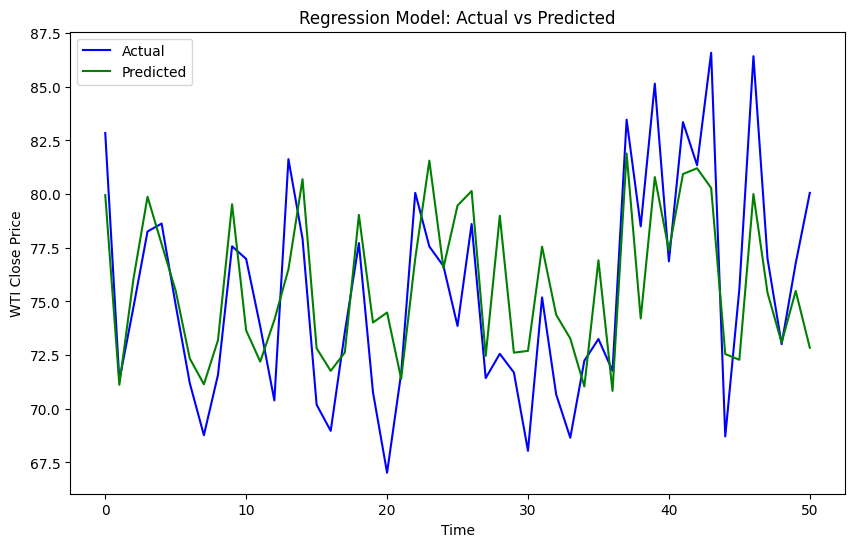

In [98]:
y_test_reset = y_test.reset_index(drop=True)


plt.figure(figsize=(10, 6))
plt.plot(y_test_reset, label='Actual', color='blue')
plt.plot(y_pred_reg, label='Predicted', color='green')
plt.title('Regression Model: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('WTI Close Price')
plt.legend()
plt.show()

### 4.1.1 Assumption Checks
---
- **Homoskedasticity**: ...
- **Serial Correlation**: ...
- **Multicollinearity**:
    - ...


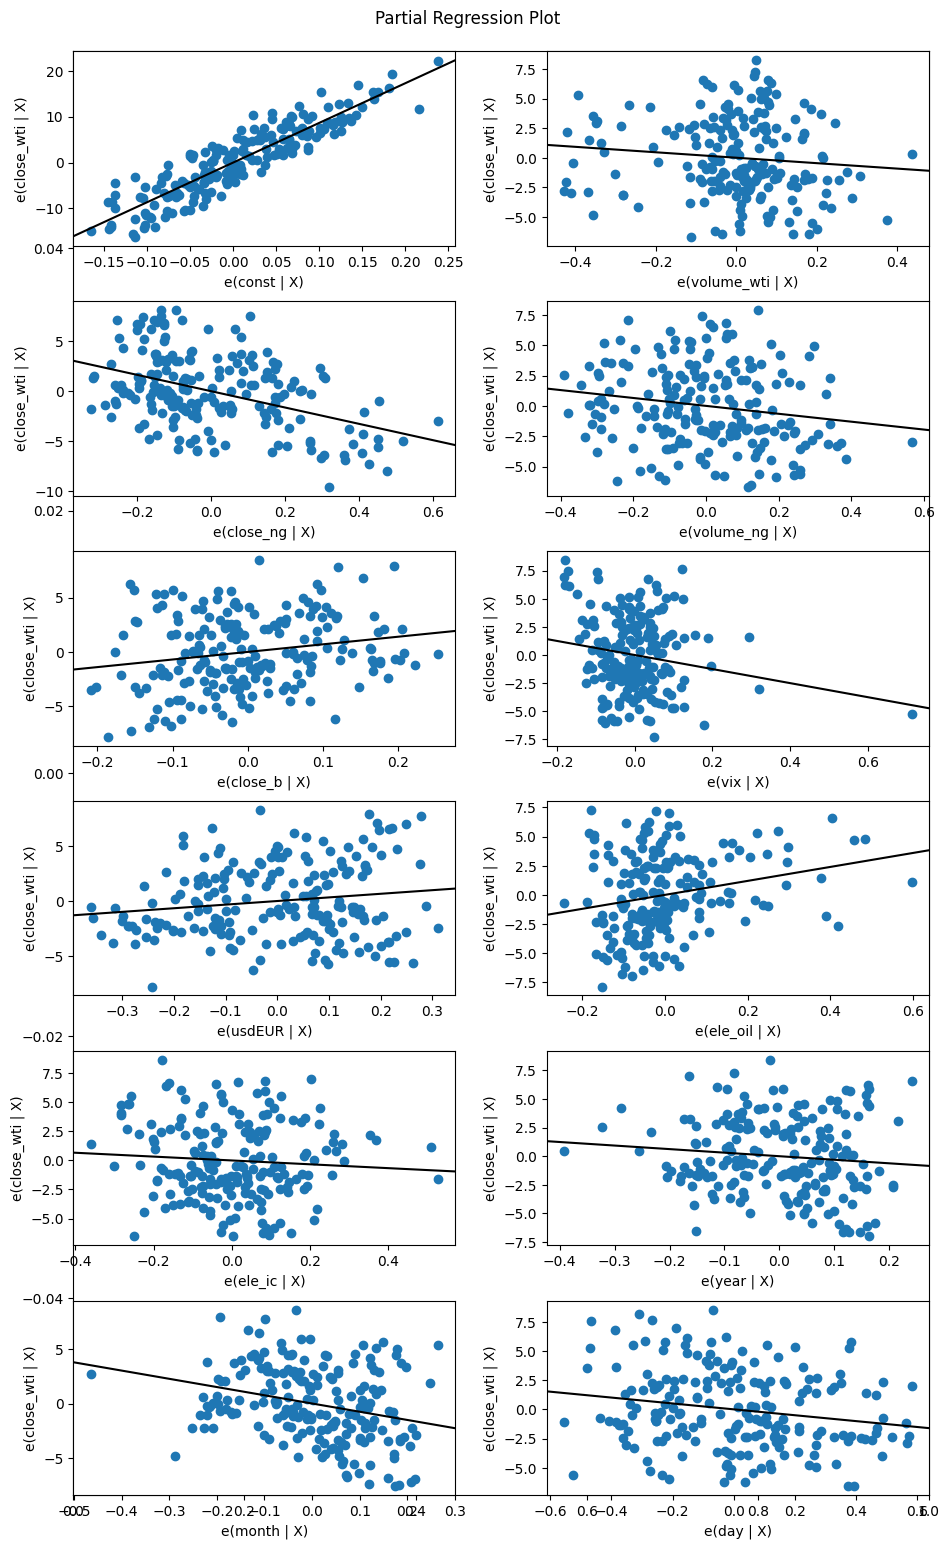

In [27]:
# Residual Analysis

fig, ax = plt.subplots(figsize=(10,16))

fig = sm.graphics.plot_partregress_grid(regression_model, fig=fig)

for ax in fig.axes:
    ax.autoscale(enable=True, axis='y')

fig.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)

plt.show()

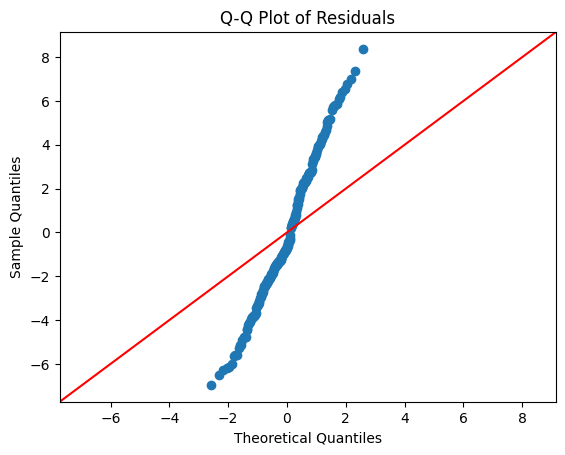

In [28]:
# Q-Q plot
sm.qqplot(regression_model.resid, line='45')
plt.title("Q-Q Plot of Residuals")
plt.show()

In [29]:
# Perform the BP test - Homoskedasticity

bp_test = het_breuschpagan(regression_model.resid, regression_model.model.exog)

bp_stat = bp_test[0]
bp_p_value = bp_test[1]

print("\nBreusch-Pagan test for heteroskedasticity:")
print(f"Test Statistic: {bp_stat:.4f}")
print(f"P-value: {bp_p_value:.4f}")

if bp_p_value < 0.05:
    print("Heteroskedasticity detected (reject null hypothesis).")
else:
    print("No significant heteroskedasticity detected (fail to reject null hypothesis).")


Breusch-Pagan test for heteroskedasticity:
Test Statistic: 35.4705
P-value: 0.0002
Heteroskedasticity detected (reject null hypothesis).


In [30]:
# Perform the BG test for autocorrelation
bg_test = acorr_breusch_godfrey(regression_model, nlags=1)

print("\nBreusch-Godfrey test for autocorrelation:")
print(f"Test Statistic: {bg_test[0]:.4f}")
print(f"P-value: {bg_test[1]:.4f}")

if bg_test[1] < 0.05:
    print("Autocorrelation detected (reject null hypothesis).")
else:
    print("No significant autocorrelation detected (fail to reject null hypothesis).")


Breusch-Godfrey test for autocorrelation:
Test Statistic: 0.4211
P-value: 0.5164
No significant autocorrelation detected (fail to reject null hypothesis).


In [31]:
# Perform VIF for multicollinearity
variables = df_model[features]

vif_data = pd.DataFrame()
vif_data['Variable'] = variables.columns
vif_data['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

vif_data

Variable          VIF
0   volume_wti    13.664980
1     close_ng    45.152696
2    volume_ng    13.704221
3      close_b    39.769128
4          vix    32.652178
5       usdEUR  8044.009417
6      ele_oil     3.369431
7       ele_ic     1.687246
8         year  7893.635968
9        month     7.520490
10         day     5.741200

### 4.1.2 Influence Analysis

In [32]:
influence = regression_model.get_influence()

influence_summary = influence.summary_frame()
influence_summary

dfb_const  dfb_volume_wti  dfb_close_ng  dfb_volume_ng  dfb_close_b  \
0     0.044847        0.023067     -0.032604       0.011078     0.050071   
1    -0.124565       -0.061502      0.055120       0.043586    -0.153203   
2    -0.098875        0.072808     -0.020338       0.055085    -0.041402   
3    -0.090956        0.128771      0.087094       0.063065     0.002175   
4    -0.102618       -0.006681      0.012414       0.039766    -0.138657   
..         ...             ...           ...            ...          ...   
195  -0.008304       -0.000862     -0.003233       0.003509    -0.005673   
196   0.104573       -0.023468      0.019921      -0.057990     0.038581   
197  -0.081882       -0.051760     -0.124911       0.215631    -0.052954   
198  -0.006383        0.000017     -0.008959      -0.001003    -0.008785   
199  -0.134826        0.121933     -0.021588       0.052072    -0.073527   

      dfb_vix  dfb_usdEUR  dfb_ele_oil  dfb_ele_ic  dfb_year  dfb_month  \
0   -0.022182   -0.026852    -0.018507   -0.082810 -0.029957  -0.023710   
1    0.081732    0.026622    -0.048854    0.077006  0.151326   0.142230   
2    0.010295    0.075812     0.083301    0.093071  0.021981   0.014309   
3   -0.015038    0.061502     0.291226    0.056971 -0.022997  -0.034007   
4   -0.029427    0.122919     0.001150   -0.013566  0.096952   0.106256   
..        ...         ...          ...         ...       ...        ...   
195 -0.006629    0.003528     0.003419    0.011816  0.008408   0.007316   
196  0.028655   -0.023979    -0.023529   -0.048596 -0.101630  -0.042765   
197  0.141904    0.184559     0.009611    0.055858  0.008468  -0.004784   
198 -0.011798   -0.011935    -0.006769    0.005802  0.014027   0.015154   
199  0.018692    0.098777     0.095332    0.116867  0.040356   0.033093   

      dfb_day   cooks_d  standard_resid  hat_diag  dffits_internal  \
0    0.027109  0.001361        0.822155  0.023598         0.127812   
1   -0.012642  0.009459        1.824056  0.032989         0.336905   
2    0.149325  0.004001        1.075512  0.039852         0.219116   
3    0.083530  0.012178        1.277526  0.082184         0.382284   
4    0.081694  0.003364       -0.828529  0.055539        -0.200915   
..        ...       ...             ...       ...              ...   
195 -0.005865  0.000033        0.116315  0.028230         0.019825   
196 -0.002403  0.002275        0.472108  0.109122         0.165230   
197  0.101819  0.014696        1.777456  0.052869         0.419947   
198  0.005590  0.000073        0.163197  0.031978         0.029661   
199  0.175786  0.005522        1.057308  0.055962         0.257426   

     student_resid    dffits  
0         0.821444  0.127702  
1         1.835513  0.339021  
2         1.075963  0.219208  
3         1.279691  0.382932  
4        -0.827835 -0.200747  
..             ...       ...  
195       0.116010  0.019773  
196       0.471130  0.164888  
197       1.787808  0.422393  
198       0.162773  0.029585  
199       1.057642  0.257508  

[200 rows x 18 columns]

In [33]:
# Detect high leverage points
k = 11  # Number of independent variables
n = 200  # Total number of observations
threshold = 3 * ((k + 1) / n)

influence_summary[influence_summary['hat_diag'] > threshold]

dfb_const  dfb_volume_wti  dfb_close_ng  dfb_volume_ng  dfb_close_b  \
90  -0.047497       -0.003918      -0.04951       0.026604    -0.043032   

     dfb_vix  dfb_usdEUR  dfb_ele_oil  dfb_ele_ic  dfb_year  dfb_month  \
90 -0.196479   -0.010974    -0.073368    0.010259  0.089167   0.094983   

     dfb_day   cooks_d  standard_resid  hat_diag  dffits_internal  \
90  0.017682  0.004063       -0.287128  0.371603          -0.2208   

    student_resid   dffits  
90      -0.286427 -0.22026

In [34]:
# Studentized Residuals
alpha = 0.05  # Significance level

Df = n - k - 1

t_critical = t.ppf(1 - alpha/2, Df)

influence_summary[abs(influence_summary['student_resid'])>t_critical ]

dfb_const  dfb_volume_wti  dfb_close_ng  dfb_volume_ng  dfb_close_b  \
14    0.053497        0.059990      0.102738       0.149802     0.028472   
28   -0.209671        0.076170      0.049314       0.009249    -0.233194   
52   -0.278849        0.049247     -0.080890      -0.010323    -0.264206   
74    0.085399        0.043025     -0.107909       0.048134     0.189584   
101   0.063339        0.032611      0.067203       0.089922     0.276996   
165   0.179993        0.078346     -0.057988       0.015451     0.286643   
192  -0.428005        0.117034     -0.263785       0.217345    -0.190340   

      dfb_vix  dfb_usdEUR  dfb_ele_oil  dfb_ele_ic  dfb_year  dfb_month  \
14   0.245096   -0.039197    -0.253432   -0.226792 -0.029404  -0.050226   
28  -0.156455    0.264489    -0.107210    0.014654  0.211769   0.175650   
52  -0.314866    0.186032    -0.027502    0.223276  0.350190   0.345708   
74   0.054728   -0.124310     0.010615    0.088553 -0.112320  -0.119485   
101  0.119838   -0.241018     0.087927   -0.003941 -0.208241  -0.137460   
165  0.084288   -0.167015    -0.042562   -0.038706 -0.209125  -0.218838   
192 -0.084784    0.248353     0.184164    0.271126  0.214270   0.366169   

      dfb_day   cooks_d  standard_resid  hat_diag  dffits_internal  \
14  -0.048617  0.028067        2.529331  0.050013         0.580346   
28   0.222763  0.015488        2.034169  0.042984         0.431104   
52  -0.198118  0.023806        2.224194  0.054595         0.534488   
74  -0.160133  0.013921        2.097782  0.036571         0.408716   
101  0.119897  0.016124       -1.962834  0.047819        -0.439872   
165 -0.104735  0.012347        1.959892  0.037139         0.384915   
192  0.327859  0.033259       -2.136844  0.080381        -0.631750   

     student_resid    dffits  
14        2.566643  0.588907  
28        2.051453  0.434767  
52        2.248045  0.540220  
74        2.117121  0.412484  
101      -1.977979 -0.443266  
165       1.974953  0.387873  
192      -2.157515 -0.637861

In [35]:
# Cook's Distance
cook_d_threshold = np.sqrt(k / n)

influence_summary[influence_summary['cooks_d'] > cook_d_threshold]

Empty DataFrame
Columns: [dfb_const, dfb_volume_wti, dfb_close_ng, dfb_volume_ng, dfb_close_b, dfb_vix, dfb_usdEUR, dfb_ele_oil, dfb_ele_ic, dfb_year, dfb_month, dfb_day, cooks_d, standard_resid, hat_diag, dffits_internal, student_resid, dffits]
Index: []

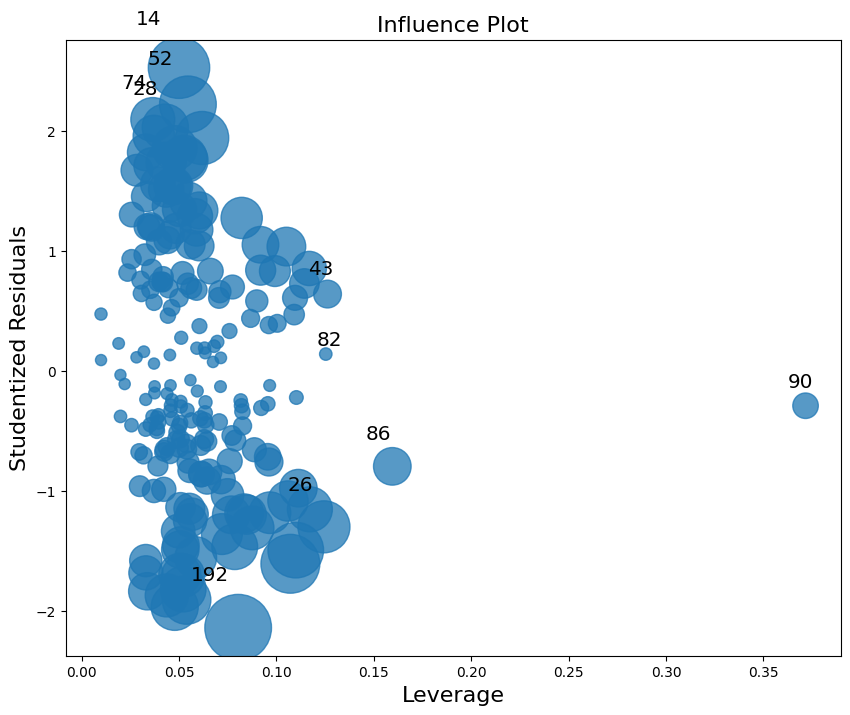

In [36]:
fig, ax = plt.subplots(figsize=(10, 8))
influence.plot_influence(ax=ax)

plt.show()

### 4.1.3 Cleaned model (excluding influential points based on studentized residuals)

In [37]:
influential_points = influence_summary[abs(influence_summary['student_resid']) > t_critical]

train_data_cleaned = X_train_scaled_df_reset.drop(influential_points.index)
y_train_cleaned = y_train_reset.drop(influential_points.index)

regression_model_cleaned = sm.OLS(y_train_cleaned, train_data_cleaned).fit()

y_pred_cleaned = regression_model_cleaned.predict(X_test_scaled_df)

print(regression_model_cleaned.summary())

                            OLS Regression Results                            
Dep. Variable:              close_wti   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     26.26
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           5.19e-32
Time:                        01:19:04   Log-Likelihood:                -489.36
No. Observations:                 193   AIC:                             1003.
Df Residuals:                     181   BIC:                             1042.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.1076      2.886     30.528      0.0

In [38]:
rmse_cleaned = np.sqrt(mean_squared_error(y_test, y_pred_cleaned))

print(f"RMSE for the cleaned model: {rmse_cleaned:.4f}")

RMSE for the cleaned model: 3.3121


## 4.2 XGBoost
---

In [39]:
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

### Model 1: Hyperparameter tuning to identify optimal model

In [74]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

# xgb_model = xgb.XGBRegressor()

In [75]:
param_grid = {
    'n_estimators': [30,40,45,50,55],
    'max_depth': [2,3,4,5],
    'learning_rate': [0.01, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1,2,3,4,5,6,7]
}


grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='r2',
                           n_jobs=-1,
                           verbose=1)

In [76]:
grid_search.fit(X_train_scaled_df, y_train)

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators': [30, 40, 45, 50, 55],
                         'reg_alpha': [0, 0.1, 1],
                         'reg_lambda': [1, 2, 3, 4, 5, 6, 7]},
             scoring='r2', verbose=1)

In [77]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 40, 'reg_alpha': 1, 'reg_lambda': 3}


In [78]:
y_train_pred = best_model.predict(X_train_scaled_df)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)


y_test_pred = best_model.predict(X_test_scaled_df)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)


train_adj_r2 = adjusted_r2(train_r2, len(X_train), X_train.shape[1])
test_adj_r2 = adjusted_r2(test_r2, len(X_test), X_test.shape[1])


print(f"Model Performance (Training Set)")
print(f"-------------------------------------")
print(f"Training MSE: {round(train_mse,3)}")
print(f"Training RMSE: {round(train_rmse,3)}")
print(f"Training R-squared: {round(train_r2,3)}")
print(f"Training Adjusted R-squared: {round(train_adj_r2,3)}")

print(f"\nModel Performance (Testing Set)")
print(f"-------------------------------------")
print(f"Testing MSE: {round(test_mse,3)}")
print(f"Testing RMSE: {round(test_rmse,3)}")
print(f"Testing R-squared: {round(test_r2,3)}")
print(f"Testing Adjusted R-squared: {round(test_adj_r2,3)}")

# Overfitting
r2_diff = train_r2 - test_r2

if r2_diff > 0.1:
    print(f"\n")
    print(f"\nOverfitting Check(Based on R-squred)")
    print(f"-------------------------------------")
    print(f"Potential overfitting detected: Training R-squared is higher than Testing R-squared by {r2_diff:.4f}")
else:
    print("\nNo significant overfitting detected.")


adj_r2_diff = train_adj_r2 - test_adj_r2

if adj_r2_diff > 0.1:
    print(f"\nOverfitting Check(Based on Adjustd R-squred)")
    print(f"-------------------------------------")
    print(f"Potential overfitting detected: Training Adjusted R-squared is higher than Testing Adjusted R-squared by {adj_r2_diff:.4f}")
else:
    print("\nNo significant overfitting detected.")

Model Performance (Training Set)
-------------------------------------
Training MSE: 0.037
Training RMSE: 0.193
Training R-squared: 0.999
Training Adjusted R-squared: 0.998

Model Performance (Testing Set)
-------------------------------------
Testing MSE: 3.428
Testing RMSE: 1.852
Testing R-squared: 0.86
Testing Adjusted R-squared: 0.821



Overfitting Check(Based on R-squred)
-------------------------------------
Potential overfitting detected: Training R-squared is higher than Testing R-squared by 0.1380

Overfitting Check(Based on Adjustd R-squred)
-------------------------------------
Potential overfitting detected: Training Adjusted R-squared is higher than Testing Adjusted R-squared by 0.1773


### Model 2: No hyperparameter tuning

In [51]:
xgb_model = xgb.XGBRegressor()

In [52]:
xgb_model.fit(X_train_scaled_df, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [53]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [54]:
cross_scores = cross_val_score(xgb_model, X_train_scaled_df, y_train, cv=cv, scoring='r2')
print(f"Cross-Validation R-squared scores: {cross_scores}")
print(f"Average CV R-squared: {np.mean(cross_scores):.3f}")

Cross-Validation R-squared scores: [0.82397847 0.89236893 0.85202306 0.83782874 0.86344704]
Average CV R-squared: 0.854


In [55]:
y_train_pred = xgb_model.predict(X_train_scaled_df)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)


y_test_pred = xgb_model.predict(X_test_scaled_df)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)


train_adj_r2 = adjusted_r2(train_r2, len(X_train), X_train.shape[1])
test_adj_r2 = adjusted_r2(test_r2, len(X_test), X_test.shape[1])


print(f"Model Performance (Training Set)")
print(f"-------------------------------------")
print(f"Training MSE: {round(train_mse,3)}")
print(f"Training RMSE: {round(train_rmse,3)}")
print(f"Training R-squared: {round(train_r2,3)}")
print(f"Training Adjusted R-squared: {round(train_adj_r2,3)}")

print(f"\nModel Performance (Testing Set)")
print(f"-------------------------------------")
print(f"Testing MSE: {round(test_mse,3)}")
print(f"Testing RMSE: {round(test_rmse,3)}")
print(f"Testing R-squared: {round(test_r2,3)}")
print(f"Testing Adjusted R-squared: {round(test_adj_r2,3)}")

# Overfitting
r2_diff = train_r2 - test_r2

if r2_diff > 0.1:
    print(f"\n")
    print(f"\nOverfitting Check(Based on R-squred)")
    print(f"-------------------------------------")
    print(f"Potential overfitting detected: Training R-squared is higher than Testing R-squared by {r2_diff:.4f}")
else:
    print("\nNo significant overfitting detected.")


adj_r2_diff = train_adj_r2 - test_adj_r2

if adj_r2_diff > 0.1:
    print(f"\nOverfitting Check(Based on Adjustd R-squred)")
    print(f"-------------------------------------")
    print(f"Potential overfitting detected: Training Adjusted R-squared is higher than Testing Adjusted R-squared by {adj_r2_diff:.4f}")
else:
    print("\nNo significant overfitting detected.")

Model Performance (Training Set)
-------------------------------------
Training MSE: 0.0
Training RMSE: 0.001
Training R-squared: 1.0
Training Adjusted R-squared: 1.0

Model Performance (Testing Set)
-------------------------------------
Testing MSE: 2.702
Testing RMSE: 1.644
Testing R-squared: 0.89
Testing Adjusted R-squared: 0.859



Overfitting Check(Based on R-squred)
-------------------------------------
Potential overfitting detected: Training R-squared is higher than Testing R-squared by 0.1100

Overfitting Check(Based on Adjustd R-squred)
-------------------------------------
Potential overfitting detected: Training Adjusted R-squared is higher than Testing Adjusted R-squared by 0.1410


### Model 3: Self-adjusted hyperparameters

In [83]:
xgb_model2 = xgb.XGBRegressor(random_state=42,max_depth=5,reg_lambda =4,n_estimators =45,reg_alpha =0)


In [84]:
xgb_model2.fit(X_train_scaled_df, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=45, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [85]:
cross_scores = cross_val_score(xgb_model2, X_train_scaled_df, y_train, cv=cv, scoring='r2')
print(f"Cross-Validation R-squared scores: {cross_scores}")
print(f"Average CV R-squared: {np.mean(cross_scores):.3f}")

Cross-Validation R-squared scores: [0.84228448 0.89767212 0.86930302 0.82548644 0.83921183]
Average CV R-squared: 0.855


In [86]:
y_train_pred = xgb_model2.predict(X_train_scaled_df)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

y_test_pred = xgb_model2.predict(X_test_scaled_df)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)


train_adj_r2 = adjusted_r2(train_r2, len(X_train), X_train.shape[1])
test_adj_r2 = adjusted_r2(test_r2, len(X_test), X_test.shape[1])


print(f"Model Performance (Training Set)")
print(f"-------------------------------------")
print(f"Training MSE: {round(train_mse,3)}")
print(f"Training RMSE: {round(train_rmse,3)}")
print(f"Training R-squared: {round(train_r2,3)}")
print(f"Training Adjusted R-squared: {round(train_adj_r2,3)}")

print(f"\nModel Performance (Testing Set)")
print(f"-------------------------------------")
print(f"Testing MSE: {round(test_mse,3)}")
print(f"Testing RMSE: {round(test_rmse,3)}")
print(f"Testing R-squared: {round(test_r2,3)}")
print(f"Testing Adjusted R-squared: {round(test_adj_r2,3)}")

# Overfitting
r2_diff = train_r2 - test_r2

if r2_diff > 0.1:
    print(f"\n")
    print(f"\nOverfitting Check(Based on R-squred)")
    print(f"-------------------------------------")
    print(f"Potential overfitting detected: Training R-squared is higher than Testing R-squared by {r2_diff:.4f}")
else:
    print("\nNo significant overfitting detected.")


adj_r2_diff = train_adj_r2 - test_adj_r2

if adj_r2_diff > 0.1:
    print(f"\nOverfitting Check(Based on Adjustd R-squred)")
    print(f"-------------------------------------")
    print(f"Potential overfitting detected: Training Adjusted R-squared is higher than Testing Adjusted R-squared by {adj_r2_diff:.4f}")
else:
    print("\nNo significant overfitting detected.")

Model Performance (Training Set)
-------------------------------------
Training MSE: 0.01
Training RMSE: 0.101
Training R-squared: 1.0
Training Adjusted R-squared: 1.0

Model Performance (Testing Set)
-------------------------------------
Testing MSE: 2.575
Testing RMSE: 1.605
Testing R-squared: 0.895
Testing Adjusted R-squared: 0.866



Overfitting Check(Based on R-squred)
-------------------------------------
Potential overfitting detected: Training R-squared is higher than Testing R-squared by 0.1044

Overfitting Check(Based on Adjustd R-squred)
-------------------------------------
Potential overfitting detected: Training Adjusted R-squared is higher than Testing Adjusted R-squared by 0.1339


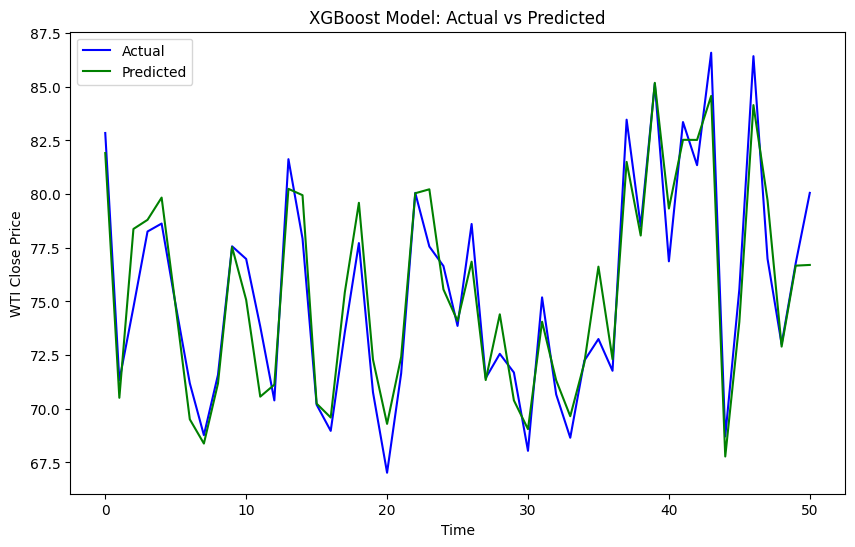

In [102]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_reset, label='Actual', color='blue')
plt.plot(y_test_pred, label='Predicted', color='green')
plt.title('XGBoost Model: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('WTI Close Price')
plt.legend()
plt.show()

### LSTM Model

In [60]:
# Feature selection (Same)
features = ['volume_wti', 'close_ng', 'volume_ng', 'close_b',
            'vix', 'usdEUR', 'ele_oil', 'ele_ic', 'year', 'month', 'day']

X = df_model[features]
y = df_model["close_wti"]

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


In [63]:
train_data_scaled = np.hstack((X_train_scaled, y_train_scaled))
test_data_scaled = np.hstack((X_test_scaled, y_test_scaled))

In [66]:
timesteps = 10

def create_dataset(data, timesteps=10):
    X, y = [], []
    for i in range(timesteps, len(data)):
        X.append(data[i-timesteps:i, :-1])
        y.append(data[i, -1])
    return np.array(X), np.array(y)

In [67]:
X_train_lstm, y_train_lstm = create_dataset(train_data_scaled, timesteps)
X_test_lstm, y_test_lstm = create_dataset(test_data_scaled, timesteps)

In [68]:
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], X_train_lstm.shape[2]))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], X_test_lstm.shape[2]))


In [69]:
def build_lstm_model(hp):
    model = Sequential()
    units = hp.Int('units', min_value=50, max_value=200, step=50)
    model.add(Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(LSTM(units=units, return_sequences=True))
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

tuner = kt.Hyperband(
    build_lstm_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='keras_tuner_dir',
    project_name='lstm_tuning'
)

In [70]:
tuner.search(X_train_lstm, y_train_lstm, epochs=20, validation_data=(X_test_lstm, y_test_lstm), batch_size=32)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Units: {best_hps.get('units')}")
print(f"Best Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Best Optimizer: {best_hps.get('optimizer')}")


Trial 30 Complete [00h 00m 15s]
val_loss: 0.058130472898483276

Best val_loss So Far: 0.05724986642599106
Total elapsed time: 00h 04m 10s
Best Units: 100
Best Dropout Rate: 0.5
Best Optimizer: rmsprop


In [71]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    validation_data=(X_test_lstm, y_test_lstm),
    batch_size=32
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.1931 - val_loss: 0.0609
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0648 - val_loss: 0.0697
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0734 - val_loss: 0.0652
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0662 - val_loss: 0.0659
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0695 - val_loss: 0.0642
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0691 - val_loss: 0.0598
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0656 - val_loss: 0.0638
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0608 - val_loss: 0.0591
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0676 - val_loss: 0.0590
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0663 - val_loss: 0.0624
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0658 - val_loss: 0.0713
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0561 - val_loss: 0.0588


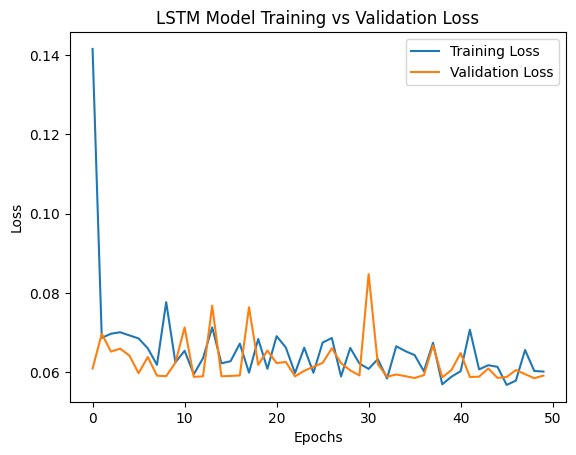

In [72]:
# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [73]:
# Evaluate the model
test_loss = best_model.evaluate(X_test_lstm, y_test_lstm)
print(f"Final Test Loss: {test_loss}")

train_loss = best_model.evaluate(X_train_lstm, y_train_lstm)
print(f"Final Train Loss: {train_loss}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0554
Final Test Loss: 0.059136681258678436
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0550 
Final Train Loss: 0.056664709001779556


In [74]:
y_pred_lstm = best_model.predict(X_test_lstm)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


In [75]:
y_pred_lstm_rescaled = scaler_y.inverse_transform(y_pred_lstm)
y_test_lstm_rescaled = scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1))

In [77]:
# Evaluate RMSE
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_rescaled, y_pred_lstm_rescaled))
print(f'LSTM Model RMSE: {rmse_lstm:.4f}')


LSTM Model RMSE: 5.1457


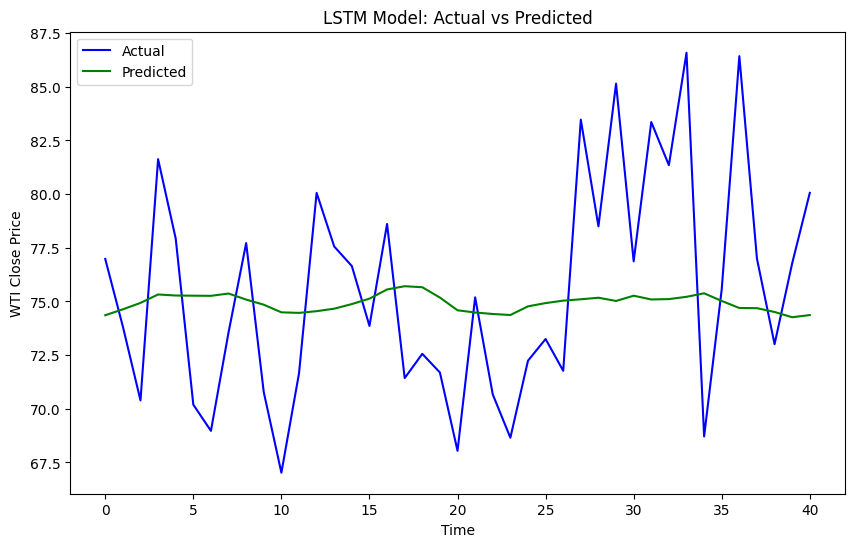

In [78]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_lstm_rescaled, label='Actual', color='blue')
plt.plot(y_pred_lstm_rescaled, label='Predicted', color='green')
plt.title('LSTM Model: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('WTI Close Price')
plt.legend()
plt.show()